# ML4NLP1
## Starting Point for Exercise 1, part II

This notebook is supposed to serve as a starting point and/or inspiration when starting exercise 1, part II.

One of the goals of this exercise is o make you acquainted with **skorch**. You will probably need to consult the [documentation](https://skorch.readthedocs.io/en/stable/).

# Installing skorch and loading libraries

In [8]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch'])
except ImportError:
    pass

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [10]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [11]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict

from sklearn.model_selection import GridSearchCV


## Training a classifier and making predictions

In [12]:
# download dataset
!gdown 1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs # x_train
!gdown 1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6 # x_test
!gdown 1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl # y_train
!gdown 1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X # y_test

Downloading...
From: https://drive.google.com/uc?id=1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs
To: /content/x_train.txt
100% 64.1M/64.1M [00:00<00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6
To: /content/x_test.txt
100% 65.2M/65.2M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl
To: /content/y_train.txt
100% 480k/480k [00:00<00:00, 97.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X
To: /content/y_test.txt
100% 480k/480k [00:00<00:00, 109MB/s]


In [13]:
with open(f'x_train.txt') as f:
    x_train = f.read().splitlines()
with open(f'y_train.txt') as f:
    y_train = f.read().splitlines()
with open(f'x_test.txt') as f:
    x_test = f.read().splitlines()
with open(f'y_test.txt') as f:
    y_test = f.read().splitlines()

In [14]:
# T: Please use again the train/test data that includes English, German, Dutch, Danish, Swedish and Norwegian, plus 20 additional languages of your choice (the labels can be found in the file labels.csv)
# and adjust the train/test split if needed

import pandas as pd
# combine x_train and y_train into one dataframe
train_df = pd.DataFrame({'text': x_train, 'label': y_train})

#combine x_test and y_test into one dataframe
test_df = pd.DataFrame({'text': x_test, 'label': y_test})


#changing 50:50 split to 70:30 split. Code to combine test and training df and split it balanced 70:30 split - Code generated by ChatGPT.
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Combine train_df and test_df into one dataframe
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Step 2: Group by label and split into training and testing while maintaining label balance
def split_data_by_label(data):
    grouped = data.groupby('label')
    train_data, test_data = [], []

    for label, group in grouped:
        group_train, group_test = train_test_split(group, test_size=0.3, random_state=42)
        train_data.append(group_train)
        test_data.append(group_test)

    train_df_balanced = pd.concat(train_data, ignore_index=True)
    test_df_balanced = pd.concat(test_data, ignore_index=True)

    return train_df_balanced, test_df_balanced

# Split the combined data
train_df_balanced, test_df_balanced = split_data_by_label(combined_df)

print("New split training dataset number of texts per language: ")
print(train_df_balanced.groupby('label').count())
print("--------------------------")
print("New split test dataset number of texts per language: ")
print(test_df_balanced.groupby('label').count())

#Make a list of languages to include. Beside prescribed languages, we chose independent languages, no dialects.
language_list=['eng', 'deu', 'nld', 'dan', 'swe', 'nob','jpn','bos', 'ces', 'cat', 'ell', 'epo', 'est', 'eus', 'fin', 'fra', 'gle', 'hbs', 'hye', 'lat', 'lav', 'ltz', 'mkd', 'pol',  'ron', 'ita']
test_df_subset=test_df_balanced[test_df_balanced.label.isin(language_list)]
train_df_subset=train_df_balanced[train_df_balanced.label.isin(language_list)]

New split training dataset number of texts per language: 
        text
label       
ace      700
afr      700
als      700
amh      700
ang      700
...      ...
yid      700
yor      700
zea      700
zh-yue   700
zho      700

[235 rows x 1 columns]
--------------------------
New split test dataset number of texts per language: 
        text
label       
ace      300
afr      300
als      300
amh      300
ang      300
...      ...
yid      300
yor      300
zea      300
zh-yue   300
zho      300

[235 rows x 1 columns]


In [15]:
# T: use your adjusted code to encode the labels here
from sklearn.preprocessing import LabelEncoder

#extract y_train and y_test from original df
y_train=train_df_subset['label']
y_test=test_df_subset['label']

x_test=test_df_subset['text']

#encode y labels
label_encoder=LabelEncoder()
le_fitted = label_encoder.fit(y_train)
y_train = le_fitted.transform(y_train)
y_test = le_fitted.transform(y_test)


In [ ]:
# T: In the following, you can find a small (almost) working example of a neural network. Unfortunately, again, the cat messed up some of the code. Please fix the code such that it is executable.

In [16]:
# First, we extract some simple features as input for the neural network
from sklearn.feature_extraction.text import CountVectorizer



vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=100, binary=True)
X = vectorizer.fit_transform(train_df_subset['text'].to_numpy())

x_train=train_df_subset['text']


In [17]:
X = X.astype(np.float32)
y = y_train.astype(np.int64)

### Run number 1
**ngram_size**: (2,2)

**solver: SGD**,

**learning_rage**: 0.01

**activation function hidden layers**: F.relu

**output activation**: function


**early stopping**: On with threshold 0.0001 and patience=10

**number of hidden layers and size**: 2 layers with 10,000 and 100 Neurons

**output activation function**: Sigmaoid function


**Performance**: f1 score of 0.57 -> below required accuracy. Also the network trains very slow due to small learning rate

In the following, we define a vanilla neural network with two hidden layers. The output layer should have as many outputs as there are classes. In addition, it should have a nonlinearity function.

In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.0001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10000,
            nonlin=F.relu,
            output_act=nn.Sigmoid()
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(18200, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 50)
        self.nonlin = nonlin
        #self.dense2 = nn.Linear(6000, 50)

        self.output = nn.Linear(50, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
   # device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(2, 2), max_features=18200)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(2, 2), 18200]


In [ ]:
pipe.fit(x_train, y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   4.9s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2588       0.0313        3.2584  3.1698
      2        3.2587       0.0316        3.2584  2.9854
      3        3.2587       0.0316        3.2583  2.9359
      4        3.2587       0.0327        3.2583  3.2223
      5        3.2586       0.0332        3.2583  2.9149
      6        3.2586       0.0343        3.2582  2.8815
      7        3.2586       0.0343        3.2582  2.8832
      8        3.2585       0.0360        3.2582  3.1923
      9        3.2585       0.0363        3.2582  2.9188
     10        3.2585       0.0379        3.2581  2.9409
     11        3.2584       0.0390        3.2581  2.9552
     12        3.2584       0.0398        3.2581  3.2794
     13        3.2584       0.0409        3.2580  2.9745
     14        3.2584       0.0426        3.2580  2.9565
     15        3.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7b98fcbd03d0>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=18200, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
y_predict=pipe.predict(x_test)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.5708974358974359


### Run number 2
Main differences: learning rate increase to 0.05 and layers sizes (first layer smaller), increased early stopping threshold to 0.001
**ngram_size**: (2,2)

**solver: SGD**,

**learning_rage**: 0.05


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 2 layers with 600 and 50 Neurons

**output activation function**: Sigmaoid function


**Performance**: f1 score of 0.64 -> below required accuracy. Network trained sigificantly faster than first run.


In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=600,
            nonlin=F.relu,
            output_act=nn.Sigmoid()
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(18200, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 50)
        self.nonlin = nonlin
        #self.dense2 = nn.Linear(6000, 50)

        self.output = nn.Linear(50, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
   # device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(2, 2), max_features=18200)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(2, 2), 18200]


In [ ]:
pipe.fit(x_train, y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   4.8s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2599       0.0385        3.2583  3.0280
      2        3.2598       0.0385        3.2582  2.9110
      3        3.2597       0.0429        3.2581  3.1839
      4        3.2596       0.0456        3.2580  2.8708
      5        3.2595       0.0588        3.2579  2.8965
      6        3.2594       0.0514        3.2578  2.9599
      7        3.2593       0.0475        3.2577  3.1536
      8        3.2592       0.0451        3.2575  2.8970
      9        3.2590       0.0445        3.2574  2.9022
     10        3.2589       0.0442        3.2573  3.0338
     11        3.2587       0.0442        3.2571  3.0975
     12        3.2586       0.0442        3.2570  2.8992
     13        3.2584       0.0445        3.2568  2.9584
     14        3.2582       0.0451        3.2566  3.0716
     15        3.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7b98fc6bcf40>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=18200, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.6446153846153846


### Run number 3
Main differences: changed nggram_size to (1,2) to also capture single word, which were  most important to Logistic Regression. Third hidden layer added, ngram_size changed to 1,2 and learning rate increased to 0.1

**ngram_size**: (1,2)

**solver: SGD**,

**learning_rage**: 0.1


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 3 hidden layers with 6000, 500 and 50 Neurons

**output activation function**: Sigmaoid function


**Performance**: f1 score of 0.7 -> increase in accuracy ,but still below required accuracy. Network trained slower due to additional layer.

In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=600,
            nonlin=F.relu,
            output_act=nn.Sigmoid()
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(18200, 6000)

        self.dense1 = nn.Linear(6000, 500)

        self.dense2 = nn.Linear(500, 50)


        self.output = nn.Linear(50, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.nonlin(self.dense1(X))
      X = self.nonlin(self.dense2(X))
      X = self.output_activation(self.output(X))
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.1,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
    device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 2), max_features=18200)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 2), 18200]


In [ ]:
pipe.fit(x_train, y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   6.6s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2609       0.0390        3.2570  4.3267
      2        3.2593       0.0407        3.2552  4.2075
      3        3.2569       0.0703        3.2521  4.2995
      4        3.2528       0.1723        3.2463  4.2659
      5        3.2436       0.2264        3.2319  4.2794
      6        3.2189       0.1816        3.1938  4.2670
      7        3.1725       0.1690        3.1443  4.2716
      8        3.1250       0.1984        3.1014  4.3272
      9        3.0805       0.2132        3.0544  4.2253
     10        3.0237       0.2228        2.9898  4.2714
     11        2.9474       0.2415        2.9200  4.2801
     12        2.8681       0.2926        2.8569  4.2364
     13        2.7947       0.3085        2.7995  4.3335
     14        2.7359       0.3445        2.7443  4.2749
     15        2.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7b98fcbd1a50>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=18200, out_features=6000, bias=True)
    (dense1): Linear(in_features=6000, out_features=500, bias=True)
    (dense2): Linear(in_features=500, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.7041025641025641


### Run number 4
Main differences: back to two hidden layers with n_gram size (1,2)  and reduced size of firsth idden layer model trains faster

**ngram_size**: (1,2)

**solver: SGD**,

**learning_rage**: 0.05


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 2 hidden layers with 600, 50 Neurons

**output activation function**: Sigmaoid function


**Performance**: f1 score of 0.77 -> increase in accuracy while decreasing run time,but still below required accuracy.





In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=600,
            nonlin=F.relu,
            output_act=nn.Sigmoid()
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(18200, num_units)

        self.dense1 = nn.Linear(num_units, 50)

        #self.dense2 = nn.Linear(6000, 50)

        self.output = nn.Linear(50, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
   # device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 2),  max_features=18200)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 2), 18200]


In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.7707692307692307


### Run number 5
Main differences: ngram_size to (1,1)

**ngram_size**: (1,1)

**solver: SGD**,

**learning_rage**: 0.05


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 2 hidden layers with 600, 50 Neurons

**output activation function**: Sigmaoid function


**Performance**: f1 score of 0.75 -> slight decrease in accuracy -> below required accuracy

In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=600,
            nonlin=F.relu,
            output_act=nn.Sigmoid()
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(18200, num_units)

        self.dense1 = nn.Linear(num_units, 50)

        #self.dense2 = nn.Linear(6000, 50)

        self.output = nn.Linear(50, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
   # device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 1),  max_features=18200)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 1), 18200]


In [ ]:
pipe.fit(x_train, y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   2.5s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2588       0.0396        3.2557  3.1263
      2        3.2556       0.0673        3.2519  3.0843
      3        3.2510       0.0984        3.2465  3.0916
      4        3.2444       0.1363        3.2384  3.3434
      5        3.2344       0.1854        3.2261  3.4831
      6        3.2192       0.2294        3.2071  3.6413
      7        3.1969       0.2690        3.1807  3.5244
      8        3.1678       0.3052        3.1486  3.0913
      9        3.1339       0.3519        3.1123  3.0953
     10        3.0965       0.4030        3.0732  3.0853
     11        3.0564       0.4651        3.0317  3.2391
     12        3.0137       0.5005        2.9881  3.0199
     13        2.9691       0.5165        2.9436  3.8193
     14        2.9241       0.5481        2.9000  3.4706
     15        2.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7b990073b640>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=18200, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.7552564102564103


### Run number 6
Main differences: increased number of max features to 50,000. Added dropout layer after firest and second hidden layer to improve the model fit.

**ngram_size**: (1,1)

**solver: SGD**,

**learning_rage**: 0.05


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 2 hidden layers with 500 & 100 Neurons

**output activation function**: Sigmaoid function

**dropout probabilty**: 0.5


**Performance**: f1 score of 0.82 -> accuracy above required threshold

In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=500,
            nonlin=F.relu,
            output_act=nn.Sigmoid(),
            dropout=0.5
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(50000, num_units)

        self.dense1 = nn.Linear(num_units, 100)

        self.dropout=nn.Dropout(dropout)
        #self.dense2 = nn.Linear(6000, 50)



        self.output = nn.Linear(100, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.dropout(X)
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.dropout(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,  # Use torch.optim.SGD
    callbacks=[early_stopping],
    device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 1),  max_features=50000)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 1), 50000]


In [ ]:
pipe.fit(x_train,y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   2.7s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2582       0.0654        3.2542  4.0999
      2        3.2540       0.1313        3.2488  3.9646
      3        3.2483       0.2297        3.2413  3.9875
      4        3.2400       0.3357        3.2305  4.1352
      5        3.2291       0.3838        3.2151  3.9690
      6        3.2152       0.4327        3.1954  4.0576
      7        3.1986       0.4857        3.1724  4.0928
      8        3.1827       0.5560        3.1479  4.0211
      9        3.1651       0.6140        3.1220  3.9298
     10        3.1468       0.6453        3.0953  3.9998
     11        3.1274       0.6786        3.0673  3.8810
     12        3.1105       0.6673        3.0390  3.8746
     13        3.0924       0.6536        3.0101  3.9248
     14        3.0704       0.6549        2.9807  3.9052
     15        3.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7cc8784ce110>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=50000, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (output): Linear(in_features=100, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.8246153846153845


### Run number 7
Main differences: added different dropout probabilties for the two dropout layers

**ngram_size**: (1,1)

**solver: SGD**,

**learning_rage**: 0.1


**activation function hidden layers**: F.relu

**output activation**: Sigmoid


**early stopping**: On with threshold 0.001 and patience=20

**number of hidden layers and size**: 2 hidden layers with 500, 100 Neurons

**output activation function**: Sigmaoid function

**dropout probabilty**: 0.5 & *0.8*


**Performance**: f1 score of 0.82 -> accuracy above required threshold but no increase compared to previous version

In [18]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=500,
            nonlin=F.relu,
            output_act=nn.Sigmoid(),
            dropout1=0.8,
            dropout2=0.5
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(50000, num_units)

        self.dense1 = nn.Linear(num_units, 100)

        self.dropout1=nn.Dropout(dropout1)
        self.dropout2=nn.Dropout(dropout2)
        #self.dense2 = nn.Linear(6000, 50)



        self.output = nn.Linear(100, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.dropout1(X)
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.dropout2(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.relu,
    optimizer=torch.optim.SGD,
    callbacks=[early_stopping],
    device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 1),  max_features=50000)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 1), 50000]


In [19]:
pipe.fit(x_train,y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   2.5s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2583       0.0676        3.2541  5.4468
      2        3.2542       0.1467        3.2487  4.4184
      3        3.2487       0.2074        3.2414  3.8201
      4        3.2412       0.2788        3.2313  3.8495
      5        3.2323       0.3626        3.2181  8.0613
      6        3.2201       0.4225        3.2010  8.6855
      7        3.2066       0.4791        3.1812  11.7117
      8        3.1933       0.5212        3.1597  7.7880
      9        3.1791       0.5651        3.1367  9.0530
     10        3.1641       0.5717        3.1124  3.8222
     11        3.1468       0.5997        3.0865  6.2305
     12        3.1316       0.6077        3.0599  4.6127
     13        3.1160       0.6168        3.0327  3.7973
     14        3.0964       0.6283        3.0048  4.3898
     15        3

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7e74c72d2350>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=50000, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=100, bias=True)
    (dropout1): Dropout(p=0.8, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (output): Linear(in_features=100, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.8285897435897436


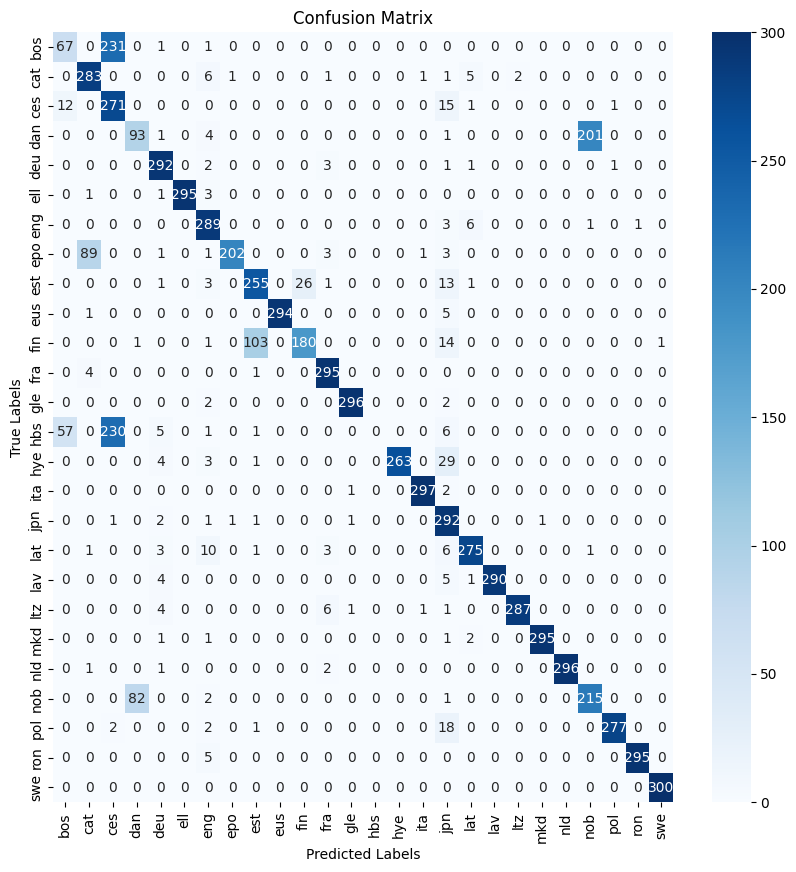

In [20]:
from sklearn.metrics import confusion_matrix
y_predict=pipe.predict(x_test)
conf_mx = confusion_matrix(y_test, y_predict)


#plot confusion matrix with seaborn -> Code for matrix was generated by ChatGPT
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
sns.heatmap(conf_mx, annot=True, fmt='d', cmap='Blues', xticklabels=le_fitted.classes_, yticklabels=le_fitted.classes_)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Different Activation function and optimizer

Used Solver Adam and hidden layera activiation funciton Adam

f1 score: 0.38 -> bad performance




In [ ]:
from sklearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='valid_loss', patience = 20, threshold = 0.001, threshold_mode='rel', lower_is_better=True)

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=500,
            nonlin=F.tanh,
            output_act=nn.Sigmoid(),
            dropout1=0.8,
            dropout2=0.5
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(50000, num_units)

        self.dense1 = nn.Linear(num_units, 100)

        self.dropout1=nn.Dropout(dropout1)
        self.dropout2=nn.Dropout(dropout2)
        #self.dense2 = nn.Linear(6000, 50)



        self.output = nn.Linear(100, 26)
        self.output_activation=output_act


    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X).float())
      X = self.dropout1(X)
      X = self.nonlin(self.dense1(X))
      #X = self.nonlin(self.dense2(X))
      X = self.output(X)
      X = self.dropout2(X)
      X = self.output_activation(X)
      return X.squeeze(dim=1)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10000,
    criterion=nn.CrossEntropyLoss,
    lr=0.05,
    module__num_units=200,
    module__nonlin=F.tanh,
    optimizer=torch.optim.Adam,
    callbacks=[early_stopping],
    device='cuda',  # comment this to train with CPU
)

class CountVectorizerWrapper:
    def __init__(self, ngram_range, max_features):
        print('args:', str([ngram_range, max_features]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

    def fit(self, X, y=None):
        self.countvec.fit(X)
        return self

    def transform(self, X, y=None):
        return self.countvec.transform(X).astype(np.float32)

vec_args = dict(ngram_range=(1, 1),  max_features=50000)
pipe = Pipeline(steps=[
        ('Vectorizer', CountVectorizerWrapper(**vec_args)),
        ('net', net)
    ], verbose=True)

args: [(1, 1), 50000]


In [ ]:
pipe.fit(x_train, y)

[Pipeline] ........ (step 1 of 2) Processing Vectorizer, total=   2.5s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.2996       0.0385        3.2836  4.2031
      2        3.2932       0.0385        3.2836  4.3214
      3        3.2895       0.0390        3.3053  4.2862
      4        3.3000       0.0629        3.3236  4.3348
      5        3.2896       0.0387        3.3051  4.3468
      6        3.2960       0.0390        3.3190  4.4831
      7        3.2946       0.1058        3.1709  4.3475
      8        3.2684       0.0964        3.1663  4.3308
      9        3.2495       0.1121        3.1568  4.2071
     10        3.2517       0.1874        3.0984  4.1866
     11        3.2398       0.1931        3.0959  4.1956
     12        3.2276       0.1838        3.1014  4.2377
     13        3.2241       0.2154        3.1101  4.2252
     14        3.2247       0.2137        3.0921  4.1767
     15        3.

Pipeline(steps=[('Vectorizer',
                 <__main__.CountVectorizerWrapper object at 0x7cfbc7b72710>),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=50000, out_features=200, bias=True)
    (dense1): Linear(in_features=200, out_features=100, bias=True)
    (dropout1): Dropout(p=0.8, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (output): Linear(in_features=100, out_features=26, bias=True)
    (output_activation): Sigmoid()
  ),
))],
         verbose=True)

In [ ]:
from sklearn.metrics import f1_score
y_predict=pipe.predict(x_test)
# Assuming you have y_predict and y_test as NumPy arrays or Python lists
# y_predict contains your predicted labels, and y_test contains the true labels

# Calculate the F1 score
f1 = f1_score(y_test,y_predict, average='micro')
print(f1)

0.3814102564102564
